### AOS duration test
performed on 3/6/20, each csv script lasted 62 minutes. We repeated 4 times.

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

In [2]:
client = EfdClient('summit_efd')
csc_index = 1

### The test lasted about 4 hours. Look at the entire data set to make sure we have everything.
* We put on 
    * bm1 positive for 37s, then 
    * bm3 positive for 37s, then 
    * bm5 positive for 37s, then 
    * bm7 positive for 37s, then 
    * bm9 positive for 37s, then 
    * go back to bm1
* so each cycle took 5*37s, 
* 5 x 37 x 20 = 3700s = 61.7 minutes. Each script ran 62 minutes = 20 cycles
* we repeated 4 times. total was 80 cycles.

In [3]:
start = Time('2020-03-06T14:30:00') #this is UTC
end = Time('2020-03-06T18:42:00') 

In [4]:
df = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

In [5]:
dft = await client.select_time_series('lsst.sal.MTM2.tangentForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

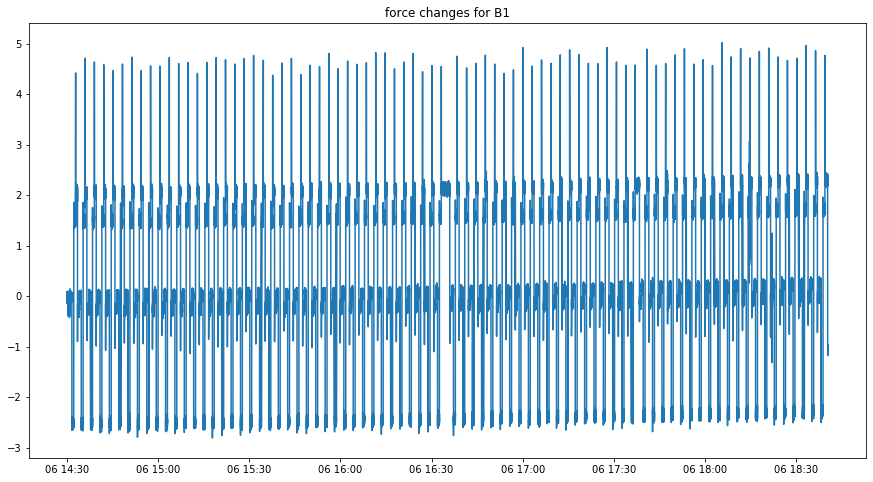

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['axialForceMeasured%d'%i]-df['axialForceMeasured%d'%i][0])
#plt.title('force changes for first 3 actuators (B1,B2,B3)');
plt.title('force changes for B1');

In [7]:
start = Time('2020-03-06T16:30:00') #this is UTC
end = Time('2020-03-06T16:40:00') 
df1 = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

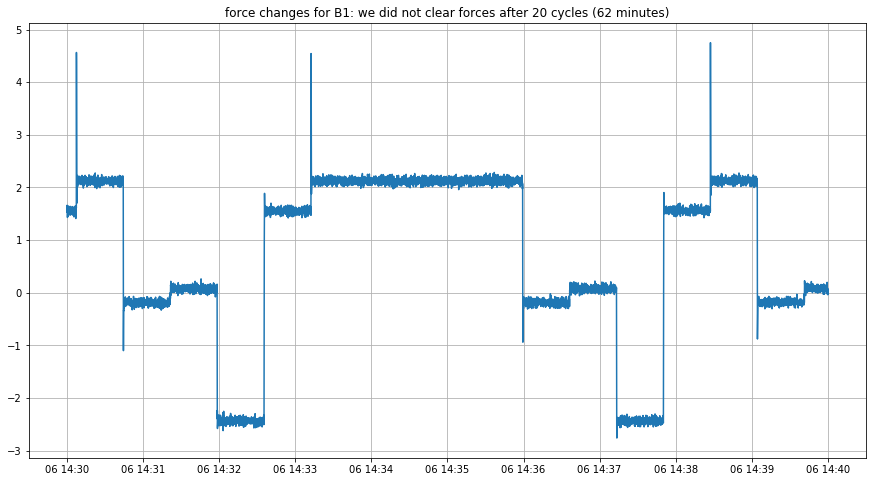

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1):
    plt.plot(pd.to_datetime(df.private_sndStamp[:12000], unit='s'), 
             df1['axialForceMeasured%d'%i][:12000]-df['axialForceMeasured%d'%i][0])
plt.title('force changes for B1: we did not clear forces after 20 cycles (62 minutes)')
plt.grid();

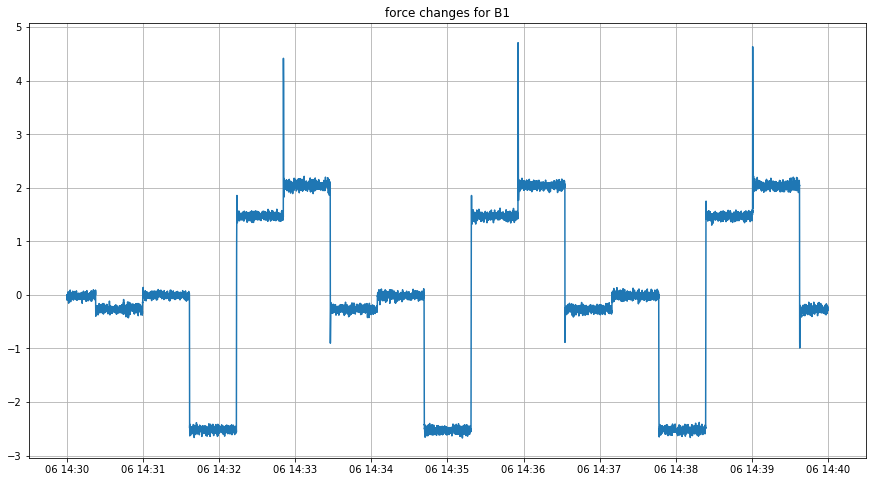

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(1):
    plt.plot(pd.to_datetime(df.private_sndStamp[:12000], unit='s'), 
             df['axialForceMeasured%d'%i][:12000]-df['axialForceMeasured%d'%i][0])
plt.title('force changes for B1')
plt.grid();

### How are we going to identify the timestamps we started each round (repeat)?
We will simply look at force on B1. Each time it goes below -2N, it is a new cycle. A cycle = 5 x 37s

493
4194
7894


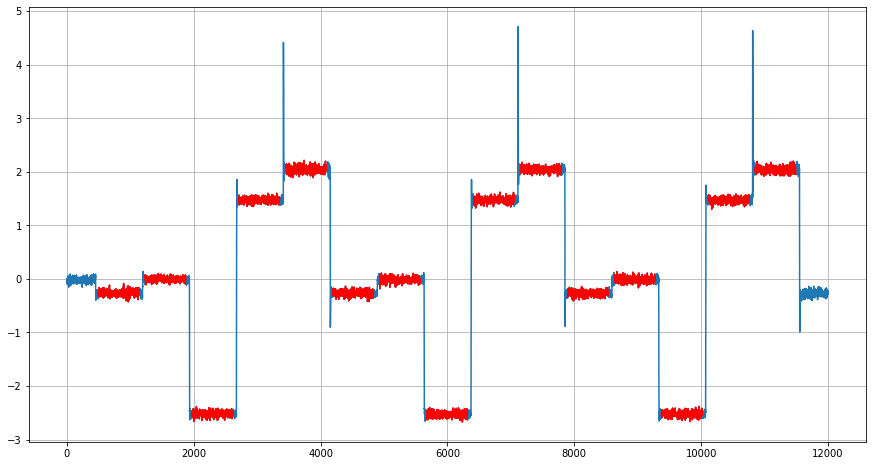

In [14]:
aa = np.array(df.axialForceMeasured0-df.axialForceMeasured0[0])
fig, ax = plt.subplots(figsize=(15,8))
#plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), aa )
plt.plot(np.arange(12000),df.axialForceMeasured0[:12000]-df.axialForceMeasured0[0])
for ic in range(3):
    base = np.argmax(aa<-2)+40-37*2*20  #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
    print(base)
    for i in range(5):
        idx = np.arange(base+i*37*20, base+i*37*20+20*32)  #32s = 15s+2s+15s (should have made 37 into 39, it is OK)
        plt.plot(idx, aa[idx], 'r')
    aa[:(base+37*20*4)] = 0
plt.grid()

### Build an array to store the data we need.

In [15]:
bm = np.zeros((5, 78, 81))
#1st dimension: bending mode
#2nd : actuator (including tangent links)
#3rd, cycle (applied forces, then cycle#1, #2, and #3... #80

#### Fill in the applied forces

In [16]:
bmIn = np.loadtxt('../github/data/M2_1um_72_force.txt')
for i in range(5):
    scalef = 1./2
    bm[i,:72,0] = bmIn[:,(2*i)+3]*scalef    

#### Fill in the measured forces
* The average of 20 x 32 data points (32s) becomes one element in the above array.

In [17]:
aa = np.array(df.axialForceMeasured0-df.axialForceMeasured0[0])
for iround in range(80):
    base = np.argmax(aa<-2)+40-37*2*20  #find 3rd bm, then walk back to 1st (1st/2nd can be confused with noise)
    assert base>0
    for i in range(5):     
        idx = np.arange(base+i*37*20, base+i*37*20+20*32)  #32s = 15s+2s+15s (should have made 37 into 39, it is OK)
        for iact in range(78):
            if iact<72:
                bm[i,iact,iround+1] = np.mean(np.array(df['axialForceMeasured%d'%iact][idx])) - \
                                           np.array(df['axialForceMeasured%d'%iact][0])
            else:
                bm[i,iact,iround+1] = np.mean(np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx])-
                                           np.array(dft['tangentLink%dDegForceMeasured'%((iact-72)*60)][idx-100]))
            if abs(bm[i,iact,iround+1] - bm[i,iact, 0])>2:
                errorS = '=============='
            else:
                errorS =''
            #print('bm%2d, act#%2d, round%d, idx[0] = %.0f, force = %.2fN/%.2fN, %s'%(
            #    2*i+1,iact+1, iround+1, idx[0], 
            #    bm[i,iact,iround+1],bm[i,iact, 0], errorS))

In [18]:
bm.shape

(5, 78, 81)

### Everything appears to be stable, except they are a bit different from the applied force. (see below)
* why didn't we see this kind of behavior with a16*ipynb? because we always went back to zero between the cyles. So our force difference was baselined using those reference forces, instead of using a single value as we do here.
* does the force difference we observe here appear to be OK? yes, it is less than the 1N force accuracy requirement. The repeatiability is also meeting the 0.1N requirement. (note that each number is an average over 32s, as compared to the 1s for the bending mode test in a16*ipynb)

In [19]:
bm[0,0,:]

array([-0.25479945, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25938392,
       -0.25938392, -0.25938392, -0.25938392, -0.25938392, -0.25

### Plot the bending forces: applied verus measured (mean and error bar).
* Error bars are due to 80 rounds of measurements

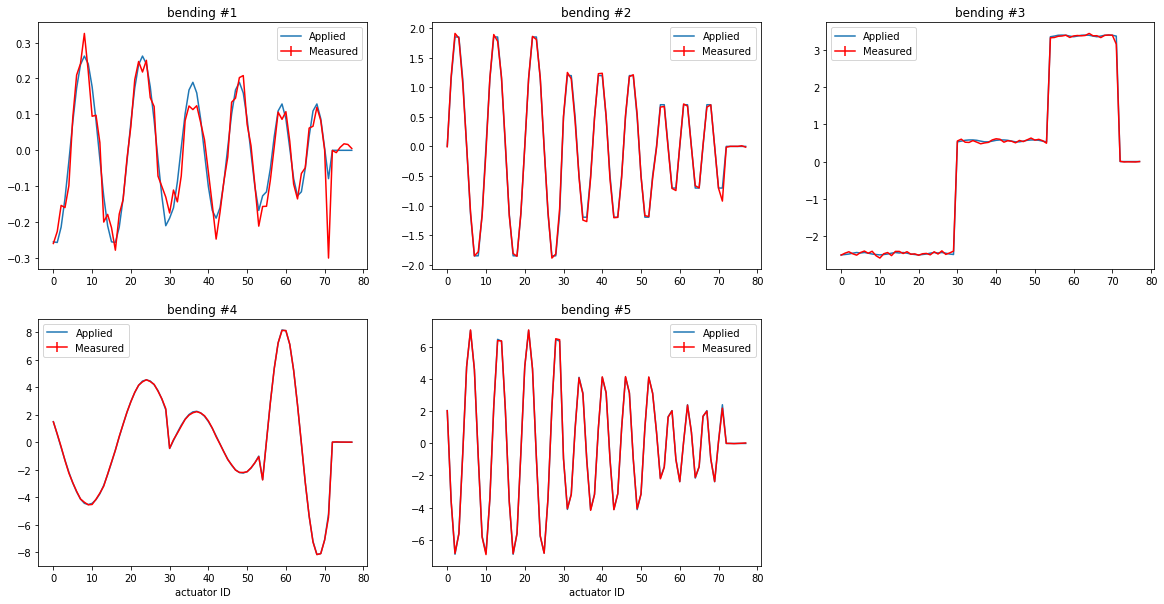

In [20]:
x0 = np.arange(78)
fig, ax = plt.subplots(2,3,figsize=(20,10))
for i in range(5):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    ax[irow][icol].plot(x0, bm[i,:,0], label='Applied')
    ax[irow][icol].errorbar(x0, np.mean(bm[i,:,1:], axis=1), np.std(bm[i,:,1:], axis=1),color='r', label='Measured')
    ax[irow][icol].set_title('bending #%d'%(i+1))
    ax[irow][icol].legend()
    if irow == 1:
        ax[irow][icol].set_xlabel('actuator ID')
fig.delaxes(ax.flatten()[-1])

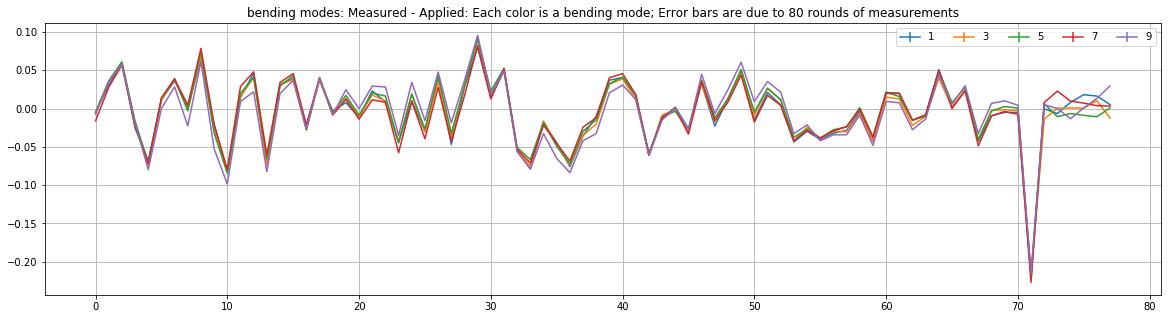

In [21]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,5))
for i in range(5):
    aa = bm[i,:,1:] - np.repeat(bm[i,:,0].reshape(-1,1),80, axis=1)
    plt.errorbar(x0, np.mean(aa, axis=1), np.std(aa, axis=1), label='%d'%(2*i+1))
plt.title('bending modes: Measured - Applied: Each color is a bending mode; \
Error bars are due to 80 rounds of measurements');
plt.grid()
plt.legend(ncol=5);

### Final force error by actuator

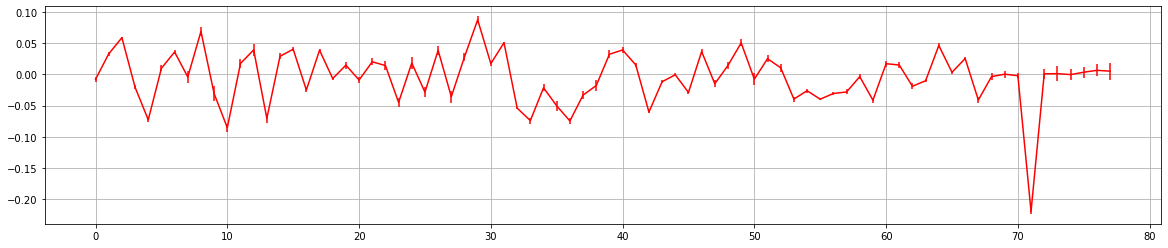

In [22]:
x0 = np.arange(78)
fig, ax = plt.subplots(figsize=(20,4))
aa = bm[:,:,1:]-np.repeat(bm[:,:,0].reshape(5,78,1),80, axis=2)
bb = np.swapaxes(aa,1,2).reshape((-1,78))
plt.errorbar(x0, np.mean(bb, axis=0), np.std(bb, axis=0),color='r')
plt.grid()